In [1]:
import glob
import pytz
import pandas as pd
import numpy as np
from pricing_benchmark import penalization_function

In [2]:
filepattern = "/home/marco/D8X/perpetual-simulation/data/index/chainlink/ETHUSD_Polygon_Mainnet*.csv"
files = glob.glob(filepattern)
assert(len(files) > 0)
print(files[0])

/home/marco/D8X/perpetual-simulation/data/index/chainlink/ETHUSD_Polygon_Mainnet_2022-12-17_2022-12-26.csv


In [3]:
df = pd.read_csv(files[0])[['roundId', 'timestamp', 'datetime', 'price']]
df = df.iloc[::-1]
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime'].apply(lambda x: x.replace(tzinfo=pytz.utc))
df['delta_time'] = df['datetime'].diff().dt.total_seconds()
df.reset_index(inplace=True, drop=True)

In [4]:
df['return'] = np.exp(np.diff(np.log(df['price']), prepend=np.nan)) - 1
df.head(5)

,roundId,timestamp,datetime,price,delta_time,return
0,36893488147422949218,1671330094,2022-12-17 21:21:34+00:00,1185.435607,NaN,NaN
1,36893488147422949219,1671330104,2022-12-17 21:21:44+00:00,1185.487366,10.0,0.000044
2,36893488147422949220,1671330114,2022-12-17 21:21:54+00:00,1185.450000,10.0,-0.000032
3,36893488147422949221,1671330124,2022-12-17 21:22:04+00:00,1185.490000,10.0,0.000034
4,36893488147422949222,1671330134,2022-12-17 21:22:14+00:00,1185.450000,10.0,-0.000034


In [5]:
df.describe()

,timestamp,price,delta_time,return
count,7.200000e+04,72000.000000,71999.000000,7.199900e+04
mean,1.671711e+09,1207.523425,10.521479,3.688767e-07
std,2.191463e+05,15.609353,4.765142,1.474296e-04
min,1.671330e+09,1153.590000,0.000000,-5.815350e-03
25%,1.671523e+09,1192.992923,10.000000,-3.369462e-05
50%,1.671710e+09,1214.718020,10.000000,0.000000e+00
75%,1.671902e+09,1218.751157,10.000000,3.275333e-05
max,1.672088e+09,1229.598550,384.000000,1.143167e-02


In [6]:
df_old = df.copy()

In [20]:
trader_pos_ema = 30 # min EMA for ETHUSD/MATIC perp
trading_fee = 2 / 10_000
minimal_spread = 0.5 / 10_000
linear_spread = 1.5 / 10_000
gas_fee = 0.0 # 10 cents per trade
trigger = 5 / 10_000 # should be more than twice the min spread

def get_spread(k, price_return):
    effective_min_spread = minimal_spread
    if np.abs(price_return) > trigger:
        # large return
        if k < 0 and price_return > 0 or k > 0 and price_return < 0:
            # price went up and trader wants to go short 
            # or price went down and trader wants to go long
            # -> increase spread
            effective_min_spread = np.abs(price_return)# - minimal_spread
    spread = effective_min_spread * np.sign(k) + linear_spread * penalization_function(k / trader_pos_ema)
    return spread



In [24]:
trade_size = 30
holding_period_blocks = 1
arb_trigger = 10 / 10_000

total_pnl = 0
total_cost = 0
locked_in = 0
is_open = False
t_last_open = np.inf
pos = 0

df = df_old.copy()
df['cumulative_pnl'] = 0
df['spread'] = np.nan
df['arb_position'] = 0

for t in range(1, df.shape[0]):
    price_return_now = df.at[t, 'price'] / df.at[t-1, 'price'] - 1
    
    if is_open and t - t_last_open >= holding_period_blocks:
        spread = get_spread(-pos, price_return_now)
        pnl = (pos) * df.at[t, 'price'] - locked_in
        cost = np.abs((-pos) * spread)
        df.at[t, 'cumulative_pnl'] = df.at[t-1, 'cumulative_pnl'] + pnl - cost
#         print(f"{t}: {df.at[t, 'cumulative_pnl']}")
        df.at[t, 'spread'] = spread
        is_open = False
        locked_in = 0
        pos = 0
        df.at[t, 'arb_position'] = 0
    elif not is_open and t < df.shape[0] - 1:
        price_return_next = df.at[t+1, 'price'] / df.at[t, 'price'] - 1
        if np.abs(price_return_next) > arb_trigger:
            pos = trade_size * np.sign(price_return_next)
            spread = get_spread(pos, price_return_now)
            locked_in = pos * df.at[t, 'price']
            is_open = True
            t_last_open = t
            df.at[t, 'cumulative_pnl'] = df.at[t-1, 'cumulative_pnl'] - np.abs(pos * spread)
            df.at[t, 'spread'] = spread
            df.at[t, 'arb_position'] = pos
        else:
            spread = get_spread(trade_size, price_return_now)
            df.at[t, 'spread'] = spread
            df.at[t, 'cumulative_pnl'] = df.at[t-1, 'cumulative_pnl']
            df.at[t, 'arb_position'] = df.at[t-1, 'arb_position']
    else:
        spread = get_spread(trade_size, price_return_now)
        df.at[t, 'spread'] = spread
        df.at[t, 'cumulative_pnl'] = df.at[t-1, 'cumulative_pnl']
        df.at[t, 'arb_position'] = df.at[t-1, 'arb_position']
        

print(df.describe())

          timestamp         price    delta_time        return  cumulative_pnl  \
count  7.200000e+04  72000.000000  71999.000000  7.199900e+04    72000.000000   
mean   1.671711e+09   1207.523425     10.521479  3.688767e-07     4057.650393   
std    2.191463e+05     15.609353      4.765142  1.474296e-04     2128.697382   
min    1.671330e+09   1153.590000      0.000000 -5.815350e-03       -0.006000   
25%    1.671523e+09   1192.992923     10.000000 -3.369462e-05     2899.170222   
50%    1.671710e+09   1214.718020     10.000000  0.000000e+00     3982.528441   
75%    1.671902e+09   1218.751157     10.000000  3.275333e-05     5825.631076   
max    1.672088e+09   1229.598550    384.000000  1.143167e-02     6619.893617   

             spread  arb_position  
count  71999.000000  72000.000000  
mean       0.000201      0.005833  
std        0.000105      1.129152  
min       -0.011582    -30.000000  
25%        0.000200      0.000000  
50%        0.000200      0.000000  
75%        0.00020

In [25]:
mask = (df['cumulative_pnl'].diff() > 0) | (df['cumulative_pnl'].diff().shift(periods=-1) > 0) | (df['cumulative_pnl'].diff().shift(periods=-2) > 0)
df[mask].tail(10)

,roundId,timestamp,datetime,price,delta_time,return,cumulative_pnl,spread,arb_position
64023,36893488147423013241,1672005275,2022-12-25 16:54:35+00:00,1217.137048,40.0,0.000441,6405.895611,0.000200,30
64024,36893488147423013242,1672005279,2022-12-25 16:54:39+00:00,1219.810000,4.0,0.002196,6486.013803,-0.002346,0
69356,36893488147423018574,1672060323,2022-12-26 08:12:03+00:00,1218.770000,12.0,-0.000041,6486.013803,0.000200,0
69357,36893488147423018575,1672060343,2022-12-26 08:12:23+00:00,1218.150000,20.0,-0.000509,6486.007803,-0.000200,-30
69358,36893488147423018576,1672060351,2022-12-26 08:12:31+00:00,1216.134049,8.0,-0.001655,6546.432187,0.001805,0
69359,36893488147423018577,1672060363,2022-12-26 08:12:43+00:00,1215.076350,12.0,-0.000870,6546.401595,0.001020,30
69360,36893488147423018578,1672060369,2022-12-26 08:12:49+00:00,1216.298600,6.0,0.001006,6583.034418,-0.001156,0
71476,36893488147423020694,1672082345,2022-12-26 14:19:05+00:00,1217.420000,10.0,0.000150,6583.034418,0.000200,0
71477,36893488147423020695,1672082363,2022-12-26 14:19:23+00:00,1217.770000,18.0,0.000287,6583.028418,0.000200,30
71478,36893488147423020696,1672082367,2022-12-26 14:19:27+00:00,1219.000000,4.0,0.001010,6619.893617,-0.001160,0


<AxesSubplot: ylabel='Frequency'>

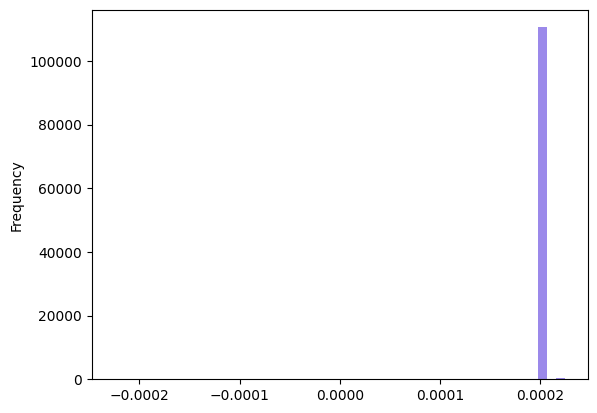

In [74]:
# df['cumulative_pnl'].plot(kind = "hist", density=True, alpha=0.65, bins=50, color="#664ADF")
df['spread'].plot(kind = "hist", density=True, alpha=0.65, bins=50, color="#664ADF")

In [27]:
trade_size = 30



# mask = df_old['return'].abs() > trigger
df = df_old.copy()
# df.loc[mask, ['return']] = np.nan
# print(df.tail(20))


df['profit_margin_rate'] = df['return'].apply(
    lambda x: np.abs(x) - 2 * np.abs(get_spread(trade_size, x)) - 2 * trading_fee
)
df['profit_qc'] = trade_size * df['price'] * df['profit_margin_rate'] - 2 * gas_fee
# df['profit_qc'].describe()
df['profit_qc'][df['profit_qc'] > 0].describe()

count    106.000000
mean      29.334547
std       55.393765
min        0.011529
25%        6.061592
50%       12.228357
75%       31.483421
max      390.599357
Name: profit_qc, dtype: float64

<AxesSubplot: ylabel='Frequency'>

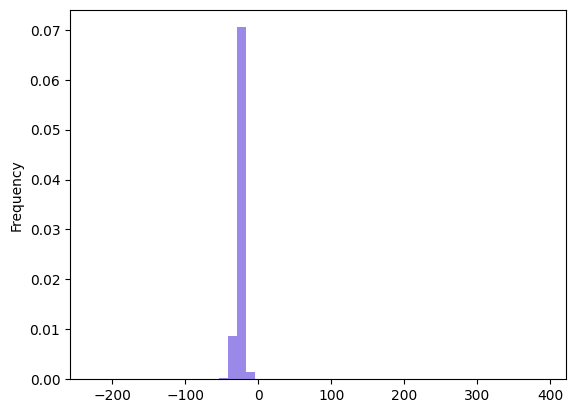

In [28]:
df['profit_qc'].plot(kind = "hist", density=True, alpha=0.65, bins=50, color="#664ADF")

In [30]:
for trade_size in [1, 5, 10, 15, 20, 25, 30]:
    df['profit_margin_rate'] = df['return'].apply(
        lambda x: np.abs(x) - 2 * np.abs(get_spread(trade_size,x)) - 2 * trading_fee
    )    
    df['profit_qc'] = trade_size * df['price'] * df['profit_margin_rate'] - 2 * gas_fee
    # df['profit_qc'].describe()
    tmp = df['profit_qc'][df['profit_qc'] > 0]
    print(f"Trade size: {trade_size}, profit per trade: {tmp.mean():.1f}, total profit in period: {tmp.sum():.1f}")

Trade size: 1, profit per trade: 0.5, total profit in period: 167.8
Trade size: 5, profit per trade: 2.9, total profit in period: 713.8
Trade size: 10, profit per trade: 7.9, total profit in period: 1250.9
Trade size: 15, profit per trade: 12.4, total profit in period: 1719.0
Trade size: 20, profit per trade: 18.2, total profit in period: 2163.7
Trade size: 25, profit per trade: 24.0, total profit in period: 2618.1
Trade size: 30, profit per trade: 29.3, total profit in period: 3109.5


In [31]:
df[(df['profit_qc'] > 0) | (df.shift(periods=1)['profit_qc'] > 0) | (df.shift(periods=-1)['profit_qc'] > 0)].head(30)

,roundId,timestamp,datetime,price,delta_time,return,profit_margin_rate,profit_qc
2472,36893488147422951690,1671355678,2022-12-18 04:27:58+00:00,1177.690000,6.0,-0.001118,-0.001818,-64.240968
2473,36893488147422951691,1671355688,2022-12-18 04:28:08+00:00,1178.869046,10.0,0.001001,0.000201,7.113942
2474,36893488147422951692,1671355698,2022-12-18 04:28:18+00:00,1178.400000,10.0,-0.000398,-0.000402,-14.215811
5410,36893488147422954628,1671386518,2022-12-18 13:01:58+00:00,1180.330000,10.0,0.000794,-0.000006,-0.209051
5411,36893488147422954629,1671386536,2022-12-18 13:02:16+00:00,1182.390000,18.0,0.001745,0.000945,33.530498
5412,36893488147422954630,1671386538,2022-12-18 13:02:18+00:00,1183.700318,2.0,0.001108,0.000308,10.944292
5413,36893488147422954631,1671386548,2022-12-18 13:02:28+00:00,1183.738321,10.0,0.000032,-0.000768,-27.269600
5414,36893488147422954632,1671386558,2022-12-18 13:02:38+00:00,1185.130000,10.0,0.001176,0.000376,13.356344
5415,36893488147422954633,1671386568,2022-12-18 13:02:48+00:00,1185.489850,10.0,0.000304,-0.000496,-17.652978
5418,36893488147422954636,1671386598,2022-12-18 13:03:18+00:00,1185.880000,10.0,0.000540,-0.000260,-9.250752


In [32]:
(df['profit_qc'][df['profit_qc'] > 25] - 20).sum()

1818.4275726434057

/home/marco/dev/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='delta_time', ylabel='profit_qc'>

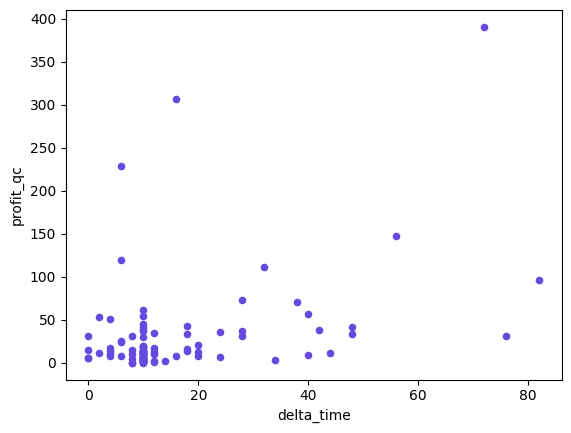

In [33]:
df[df['profit_qc'] > 0].plot.scatter('delta_time', 'profit_qc', color="#664ADF")

<AxesSubplot: xlabel='return', ylabel='delta_time'>

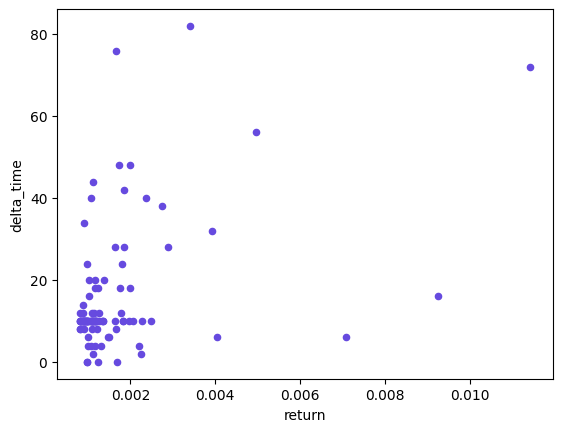

In [34]:
df[df['profit_qc'] > 0].plot.scatter('return', 'delta_time', color="#664ADF")

In [35]:
df[df['profit_qc'] > 0].shape, df.shape

((106, 8), (72000, 8))

In [ ]:
df.hsape